In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
def phi(x):
    return x / (1 - np.exp(-x))


def ode(r, tau, I, phi):
    return (-r + phi(I)) / tau


def simulate(T, dt, tau, sigma, Iext, verbose=False):

    Npoints = int(T / dt)
    sfreq = 1 / dt
    sqrt_dt = np.sqrt(dt)
    times = np.arange(0, Npoints, dt)

    __iter = range(Npoints - 1)

    if verbose:
        __iter = tqdm(__iter)

    r = np.random.rand(4, Npoints)

    for t in __iter:

        I = J @ r[:, [t]] + Iext[:, [t]]
        r[:, [t + 1]] = (
            r[:, [t]]
            + dt * ode(r[:, [t]], tau, I, phi)
            + np.sqrt(dt / tau) * np.random.normal(0, 1, (4, 1)) * sigma
        )

    return r

In [3]:
J = np.array(
    [[1.5, -3.25, 0, 0], [3.5, -2.5, 0.75, 0], [1, 0, 1.5, -3.25], [0, 0, 3.5, -2.5]]
)
tau = np.array([6, 15, 30, 75]).reshape(4, 1)
sigma = 0.3

In [4]:
T = 1000
dt = 0.1

Iext = np.zeros((4, int(T / dt)))
Iext[0, 2000:3000] = 1

In [5]:
rnull = np.stack(
    [simulate(T, dt, tau, 0.3, Iext * 0, verbose=False) for i in tqdm(range(100))], 0
)

100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.92it/s]


In [6]:
r = np.stack(
    [simulate(T, dt, tau, 0.3, Iext, verbose=False) for i in tqdm(range(100))], 0
)

100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.87it/s]


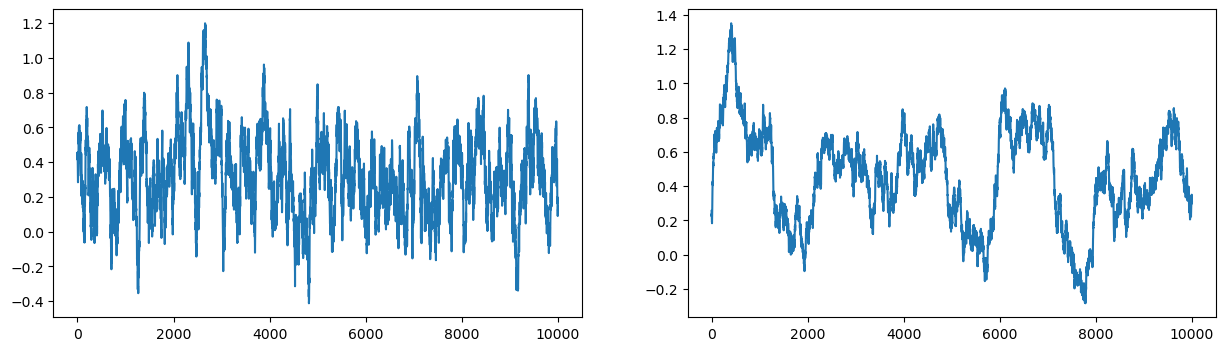

In [7]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(r[0, 0])
plt.subplot(122)
plt.plot(r[0, 2])

In [8]:
from mne.time_frequency import psd_array_multitaper

In [9]:
psdnull, freqs = psd_array_multitaper(
    rnull, 1 / (dt * 1e-3), fmin=0, fmax=80, bandwidth=3
)
psdnull = psdnull.mean(0)[0]

psd, freqs = psd_array_multitaper(r, 1 / (dt * 1e-3), fmin=0, fmax=80, bandwidth=3)
psd = psd.mean(0)[0]

    Using multitaper spectrum estimation with 2 DPSS windows
    Using multitaper spectrum estimation with 2 DPSS windows


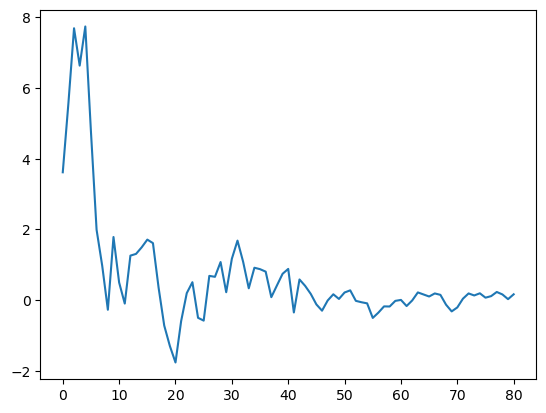

In [10]:
plt.plot(freqs, psd - psdnull)

In [11]:
J = np.array(
    [[1.5, -3.25, 0, 0], [3.5, -2.5, 0.75, 0], [1, 0, 1.5, -3.25], [0, 0, 3.5, -2.5]]
)
tau = np.array([6, 15, 30, 75]).reshape(4, 1)
sigma = np.array([0.3, 0.3, 0.45, 0.45]).reshape(4, 1)

T = 1000
dt = 0.1

Iext = np.zeros((4, int(T / dt)))
Iext[0, 6000:6200] = 1

In [12]:
r = np.stack(
    [
        simulate(T, dt, tau, sigma, Iext * (0.1 * i + 1), verbose=False)
        for i in tqdm(range(300))
    ],
    0,
)

100%|█████████████████████████████████████████| 300/300 [00:30<00:00,  9.92it/s]


In [13]:
import xarray as xr

data = xr.DataArray(
    r[:, [0, 2]],
    dims=("trials", "roi", "times"),
    coords=(np.linspace(1.1, 31, 300), ["x", "y"], np.arange(0, T, dt)),
)

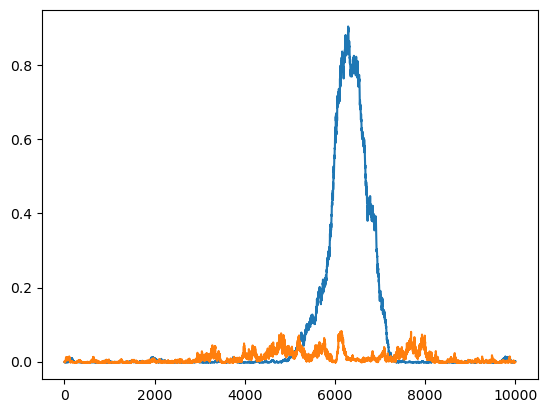

In [32]:
import scipy
from frites.core import gcmi_nd_cc

h = scipy.signal.hilbert(data, axis=2)
h = h[:, 0] * np.conj(h[:, 1])
stim = np.expand_dims(data.trials.values, 1)
stim = np.tile(stim, data.sizes["times"])

plt.plot(gcmi_nd_cc(np.abs(h), stim, traxis=0))
plt.plot(gcmi_nd_cc(np.angle(h), stim, traxis=0))

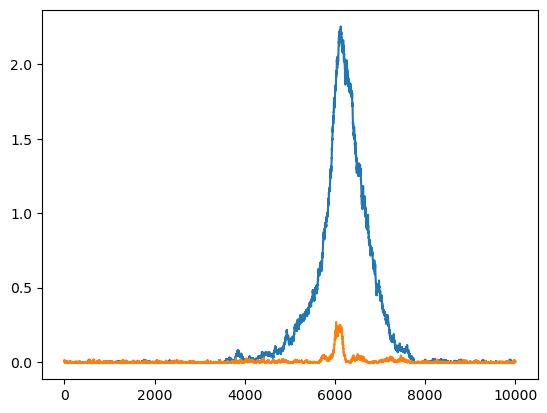

In [23]:
def phi(x):
    return x / (1 - np.exp(-x))


def ode(r, tau, I, phi):
    return (-r + phi(I)) / tau


def simulate(T, dt, tau, sigma, Iext, verbose=False):

    Npoints = int(T / dt)
    sfreq = 1 / dt
    sqrt_dt = np.sqrt(dt)
    times = np.arange(0, Npoints, dt)

    J = np.array(
        [
            [1.5, -3.25, 0, 0],
            [3.5, -2.5, 0.75, 0],
            [1, 0, 1.5, -3.25],
            [0, 0, 3.5, -2.5],
        ]
    )

    J_V4 = np.array([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])

    J_V1 = np.array([[0, 0, 0.1, 0], [0, 0, 0.5, 0], [0, 0, 0.9, 0], [0, 0, 0.5, 0]])

    __iter = range(Npoints - 1)

    if verbose:
        __iter = tqdm(__iter)

    r_V1 = np.random.rand(4, Npoints)
    r_V4 = np.random.rand(4, Npoints)

    for t in __iter:

        I_V1 = J @ r_V1[:, [t]] + J_V4 @ r_V4[:, [t]] + Iext[:, [t]]
        I_V4 = J @ r_V4[:, [t]] + J_V1 @ r_V1[:, [t]]

        r_V1[:, [t + 1]] = (
            r_V1[:, [t]]
            + dt * ode(r_V1[:, [t]], tau, I_V1, phi)
            + np.sqrt(dt / tau) * np.random.normal(0, 1, (4, 1)) * sigma
        )

        r_V4[:, [t + 1]] = (
            r_V4[:, [t]]
            + dt * ode(r_V4[:, [t]], tau, I_V4, phi)
            + np.sqrt(dt / tau) * np.random.normal(0, 1, (4, 1)) * sigma
        )

    S_V1 = .2 * r_V1[0] + .8 * r_V1[2]
    S_V4 = .2 * r_V4[0] + .8 * r_V4[2]
    
    return np.stack((S_V1, S_V4), 1)

In [24]:
r = np.stack(
    [
        simulate(T, dt, tau, sigma, Iext * (0.1 * i + 1), verbose=False)
        for i in tqdm(range(300))
    ],
    0,
)


%|                                                   | 0/300 [00:00<?, ?it/s]
%|▏                                          | 1/300 [00:00<01:08,  4.34it/s]
%|▎                                          | 2/300 [00:00<01:07,  4.41it/s]
%|▍                                          | 3/300 [00:00<01:06,  4.47it/s]
%|▌                                          | 4/300 [00:00<01:05,  4.49it/s]
%|▋                                          | 5/300 [00:01<01:05,  4.48it/s]
%|▊                                          | 6/300 [00:01<01:05,  4.48it/s]
%|█                                          | 7/300 [00:01<01:05,  4.50it/s]
%|█▏                                         | 8/300 [00:01<01:04,  4.52it/s]
%|█▎                                         | 9/300 [00:02<01:04,  4.54it/s]
%|█▍                                        | 10/300 [00:02<01:03,  4.56it/s]
%|█▌                                        | 11/300 [00:02<01:03,  4.58it/s]
%|█▋                                        | 12/300 [00:02<01:

In [31]:
data = xr.DataArray(
    r.transpose(0, 2, 1),
    dims=("trials", "roi", "times"),
    coords=(np.linspace(1.1, 31, 300), ["x", "y"], np.arange(0, T, dt)),
)

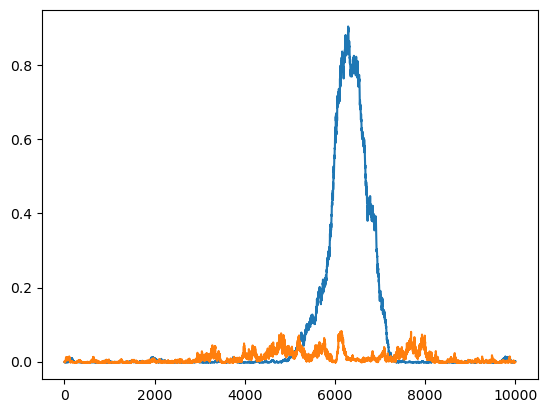

In [33]:
import scipy
from frites.core import gcmi_nd_cc

h = scipy.signal.hilbert(data, axis=2)
h = h[:, 0] * np.conj(h[:, 1])
stim = np.expand_dims(data.trials.values, 1)
stim = np.tile(stim, data.sizes["times"])

plt.plot(gcmi_nd_cc(np.abs(h), stim, traxis=0))
plt.plot(gcmi_nd_cc(np.angle(h), stim, traxis=0))

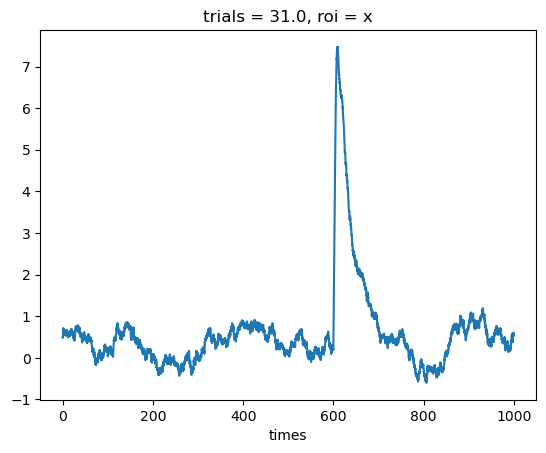

In [38]:
data[-1, 0].plot()